In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- HMIS Data (combining multiple years) ---
# Load each HMIS file and create a 'Year' column with the correct encoding
hmis_maha = pd.read_csv("hmis-item-rpt-mah-for-2016-17.csv", encoding='latin1')
hmis_maha['Year'] = '2016-17'

hmis_bihar = pd.read_csv("hmis-item-rpt-bi-for-2015-16.csv", encoding='latin1')
hmis_bihar['Year'] = '2015-16'

hmis_kerala = pd.read_csv("hmis-item-rpt-ker-for-2014-15.csv", encoding='latin1')
hmis_kerala['Year'] = '2014-15'

hmis_assam = pd.read_csv("hmis-item-rpt-as-for-2017-18.csv", encoding='latin1')
hmis_assam['Year'] = '2017-18'

# Concatenate all HMIS DataFrames into one
hmis_combined = pd.concat([hmis_maha, hmis_bihar, hmis_kerala, hmis_assam], ignore_index=True)

# --- Other Datasets ---
nfhs_data = pd.read_csv("NFHS_5_Factsheets_Data.csv", encoding='latin1')
literacy_data = pd.read_csv("Literacy Rate In India (NSSO And RGI).csv", encoding='latin1')

print("HMIS Combined DataFrame:")
print(hmis_combined.info())
print("\nNFHS Factsheets DataFrame:")
print(nfhs_data.info())
print("\nLiteracy Rate DataFrame:")
print(literacy_data.info())

HMIS Combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54234 entries, 0 to 54233
Data columns (total 83 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   District                            54234 non-null  object 
 1   S.No.                               54234 non-null  object 
 2   Parameters                          54234 non-null  object 
 3   Type                                54234 non-null  object 
 4   April                               27263 non-null  float64
 5   May                                 27077 non-null  float64
 6   June                                27261 non-null  float64
 7   July                                27489 non-null  float64
 8   August                              27515 non-null  float64
 9   September                           27782 non-null  float64
 10  October                             28020 non-null  float64
 11  November        

In [3]:
# Create a copy to avoid modifying the original dataframe
hmis_cleaned = hmis_combined.copy()

# Drop unnecessary columns
hmis_cleaned = hmis_cleaned.drop(columns=['S.No.'])

# Identify the columns to melt
# We'll melt the columns with monthly data and urban/rural breakdowns
monthly_cols = [col for col in hmis_cleaned.columns if any(month in col for month in ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March'])]
total_cols = [col for col in hmis_cleaned.columns if col.startswith('Total - ')]

# Combine all value columns to be melted
value_vars_to_melt = monthly_cols + total_cols

# Identify the columns that will remain as identifiers
id_vars = ['District', 'Parameters', 'Type', 'Year']

# Melt the DataFrame
hmis_long = hmis_cleaned.melt(id_vars=id_vars, value_vars=value_vars_to_melt, var_name='Metric', value_name='Value')

# Display the head of the new DataFrame to see the long format
print("HMIS Long Format Head:")
print(hmis_long.head())

# Display the info of the new DataFrame
print("\nHMIS Long Format Info:")
print(hmis_long.info())

HMIS Long Format Head:
     District                                         Parameters   Type  \
0  Ahmednagar  Total number of pregnant women Registered for ANC  TOTAL   
1  Ahmednagar  Of which Number registered within first trimes...  TOTAL   
2  Ahmednagar      Number of Pregnant women registered under JSY  TOTAL   
3  Ahmednagar  Number of pregnant women received 3 ANC check ...  TOTAL   
4  Ahmednagar  Number of pregnant women given TT1 during curr...  TOTAL   

      Year Metric   Value  
0  2016-17  April  7017.0  
1  2016-17  April  5499.0  
2  2016-17  April  1928.0  
3  2016-17  April  6160.0  
4  2016-17  April  4230.0  

HMIS Long Format Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176018 entries, 0 to 4176017
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   District    object
 1   Parameters  object
 2   Type        object
 3   Year        object
 4   Metric      object
 5   Value       object
dtypes: object(6)
memory usage

In [4]:
# 1. Convert 'Value' column to a numeric type
hmis_long['Value'] = pd.to_numeric(hmis_long['Value'], errors='coerce')

# 2. Simplify the 'Metric' column
# Extract 'Public', 'Private', 'Urban', 'Rural' etc. from the Metric column
hmis_long['Breakdown'] = hmis_long['Metric'].apply(lambda x: x.split(' - ')[1] if ' - ' in x else 'Total')

# Create a new column 'Period' for the month or total
hmis_long['Period'] = hmis_long['Metric'].apply(lambda x: x.split(' - ')[0] if ' - ' in x else x)

# 3. Simplify the 'Parameters' column (Create a cleaner 'Indicator' column)
# This is a sample dictionary. We'll focus on these for our analysis.
indicator_map = {
    'Total number of pregnant women Registered for ANC': 'ANC Registered',
    'Of which Number registered within first trimester': 'ANC Registered in 1st Trimester',
    'Number of institutional deliveries': 'Institutional Deliveries',
    'Number of live births': 'Live Births',
    'Number of new borns weighed at birth': 'Newborns Weighed',
    'Full Immunization coverage for children below 1 year': 'Full Immunization'
}

# Map the long parameters to our new, short indicators
hmis_long['Indicator'] = hmis_long['Parameters'].map(indicator_map)

# Drop rows where the indicator is NaN, as these aren't relevant to our core questions
hmis_long.dropna(subset=['Indicator'], inplace=True)

# Drop the original 'Metric' and 'Parameters' columns
hmis_long = hmis_long.drop(columns=['Metric', 'Parameters'])

# Display the new head and info
print("HMIS Cleaned Head:")
print(hmis_long.head())

print("\nHMIS Cleaned Info:")
print(hmis_long.info())

HMIS Cleaned Head:
        District   Type     Year   Value Breakdown Period       Indicator
0     Ahmednagar  TOTAL  2016-17  7017.0     Total  April  ANC Registered
458        Akola  TOTAL  2016-17  2721.0     Total  April  ANC Registered
916     Amravati  TOTAL  2016-17  3781.0     Total  April  ANC Registered
1374  Aurangabad  TOTAL  2016-17  7147.0     Total  April  ANC Registered
1832    Bhandara  TOTAL  2016-17  1715.0     Total  April  ANC Registered

HMIS Cleaned Info:
<class 'pandas.core.frame.DataFrame'>
Index: 6699 entries, 0 to 4161094
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   District   6699 non-null   object 
 1   Type       6699 non-null   object 
 2   Year       6699 non-null   object 
 3   Value      1044 non-null   float64
 4   Breakdown  6699 non-null   object 
 5   Period     6699 non-null   object 
 6   Indicator  6699 non-null   object 
dtypes: float64(1), object(6)
memory usage: 418.7+ KB

In [5]:
# Create a copy to work with
literacy_cleaned = literacy_data.copy()

# Rename columns to remove leading spaces and make them more descriptive
literacy_cleaned.columns = ['State', 'Rural_Male', 'Rural_Female', 'Rural_Persons', 'Urban_Male', 'Urban_Female', 'Urban_Persons']

# Drop the first row which seems to be the total/header row with no state name
literacy_cleaned = literacy_cleaned.iloc[1:]

# Reset the index after dropping the row
literacy_cleaned = literacy_cleaned.reset_index(drop=True)

# Display the head and info of the new DataFrame
print("Literacy Data Cleaned Head:")
print(literacy_cleaned.head())
print("\nLiteracy Data Cleaned Info:")
print(literacy_cleaned.info())

Literacy Data Cleaned Head:
   State  Rural_Male  Rural_Female  Rural_Persons  Urban_Male  Urban_Female  \
0   2004        72.0          50.0           61.0        88.0          75.0   
1   2005         NaN           NaN            NaN         NaN           NaN   
2   2006        75.0          52.0           64.0        89.0          77.0   
3   2007        76.0          54.0           65.0        89.0          77.0   

   Urban_Persons  
0           82.0  
1            NaN  
2           83.0  
3           84.0  

Literacy Data Cleaned Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          4 non-null      int64  
 1   Rural_Male     3 non-null      float64
 2   Rural_Female   3 non-null      float64
 3   Rural_Persons  3 non-null      float64
 4   Urban_Male     3 non-null      float64
 5   Urban_Female   3 non-null      float64


In [6]:
# Create a copy to work with
literacy_final = literacy_cleaned.copy()

# Rename the 'State' column to 'Year'
literacy_final = literacy_final.rename(columns={'State': 'Year'})

# Drop any rows with missing values
literacy_final.dropna(inplace=True)

# Display the new head and info
print("Literacy Data Final Head:")
print(literacy_final.head())
print("\nLiteracy Data Final Info:")
print(literacy_final.info())

Literacy Data Final Head:
   Year  Rural_Male  Rural_Female  Rural_Persons  Urban_Male  Urban_Female  \
0  2004        72.0          50.0           61.0        88.0          75.0   
2  2006        75.0          52.0           64.0        89.0          77.0   
3  2007        76.0          54.0           65.0        89.0          77.0   

   Urban_Persons  
0           82.0  
2           83.0  
3           84.0  

Literacy Data Final Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 0 to 3
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           3 non-null      int64  
 1   Rural_Male     3 non-null      float64
 2   Rural_Female   3 non-null      float64
 3   Rural_Persons  3 non-null      float64
 4   Urban_Male     3 non-null      float64
 5   Urban_Female   3 non-null      float64
 6   Urban_Persons  3 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 192.0 bytes
None


In [7]:
# Create a copy to work with
nfhs_final = nfhs_data.copy()

# Select only the relevant columns for our analysis
nfhs_final = nfhs_final[[
    'States/UTs',
    'Percentage of births in last 5 years that were institutional',
    'Percentage of children 12-23 months who are fully immunized',
    'Infant mortality rate (IMR)',
    'Under-five mortality rate (U5MR)'
]]

# Rename the columns for clarity
nfhs_final.columns = [
    'State',
    'Institutional_Births_Pct',
    'Full_Immunization_Pct',
    'Infant_Mortality_Rate',
    'Under_5_Mortality_Rate'
]

# Display the new head and info
print("\nNFHS Final Head:")
print(nfhs_final.head())
print("\nNFHS Final Info:")
print(nfhs_final.info())

KeyError: "['Percentage of births in last 5 years that were institutional', 'Percentage of children 12-23 months who are fully immunized', 'Infant mortality rate (IMR)', 'Under-five mortality rate (U5MR)'] not in index"

In [8]:
print(nfhs_data.columns)

Index(['States/UTs', 'Area', 'Number of Households surveyed',
       'Number of Women age 15-49 years interviewed',
       'Number of Men age 15-54 years interviewed',
       'Female population age 6 years and above who ever attended school (%)',
       'Population below age 15 years (%)',
       ' Sex ratio of the total population (females per 1,000 males)',
       'Sex ratio at birth for children born in the last five years (females per 1,000 males)',
       'Children under age 5 years whose birth was registered with the civil authority (%)',
       ...
       'Women (age 15-49 years) having a mobile phone that they themselves use (%)',
       'Women age 15-24 years who use hygienic methods of protection during their menstrual period26 (%)',
       'Ever-married women age 18-49 years who have ever experienced spousal violence27 (%)',
       'Ever-married women age 18-49 years who have experienced physical violence during any pregnancy (%)',
       'Young women age 18-29 years who exp

In [11]:
# Create a copy to work with
nfhs_final = nfhs_data.copy()

# Select a new set of columns from your output that are relevant and present
nfhs_final = nfhs_final[[
    'States/UTs',
    'Percentage of births in last 5 years that were institutional',
    'Percentage of children 12-23 months who are fully immunized (%)',
    'Female population age 6 years and above who ever attended school (%)',
    'Women age 15 years and above who use any kind of tobacco (%)',
    'Ever-married women age 18-49 years who have ever experienced spousal violence27 (%)'
]]

# Rename the columns for clarity
nfhs_final.columns = [
    'State',
    'Institutional_Births_Pct',
    'Full_Immunization_Pct',
    'Female_Literacy_Pct', # Reusing a literacy-related metric
    'Women_Tobacco_Use_Pct',
    'Spousal_Violence_Pct'
]

# Display the new head and info
print("NFHS Final Head:")
print(nfhs_final.head())
print("\nNFHS Final Info:")
print(nfhs_final.info())

KeyError: "['Percentage of births in last 5 years that were institutional', 'Percentage of children 12-23 months who are fully immunized (%)'] not in index"

In [12]:
# Create a list of all columns to inspect
all_nfhs_columns = list(nfhs_data.columns)

# Find columns related to births
births_columns = [col for col in all_nfhs_columns if 'births' in col.lower()]
print("Columns with 'births':", births_columns)

# Find columns related to immunization
immunization_columns = [col for col in all_nfhs_columns if 'immunized' in col.lower()]
print("Columns with 'immunized':", immunization_columns)

# Find columns related to female education/literacy
literacy_columns = [col for col in all_nfhs_columns if 'school' in col.lower()]
print("Columns with 'school':", literacy_columns)

# Find a column for state name
state_column = [col for col in all_nfhs_columns if 'state' in col.lower()]
print("Columns with 'state':", state_column)

Columns with 'births': ['Neonatal mortality rate (per 1000 live births)', 'Infant mortality rate (per 1000 live births)', 'Under-five mortality rate (per 1000 live births)', 'Institutional births (in the 5 years before the survey) (%)', 'Institutional births in public facility (in the 5 years before the survey) (%)', 'Home births that were conducted by skilled health personnel  (in the 5 years before the survey)10 (%)', 'Births attended by skilled health personnel (in the 5 years before the survey)10 (%)', 'Births delivered by caesarean section (in the 5 years before the survey) (%)', 'Births in a private health facility that were delivered by caesarean section (in the 5 years before the survey) (%)', 'Births in a public health facility that were delivered by caesarean section (in the 5 years before the survey) (%)']
Columns with 'immunized': []
Columns with 'school': ['Female population age 6 years and above who ever attended school (%)', 'Children age 5 years who attended pre-primary

In [13]:
# Create a copy to work with
nfhs_final = nfhs_data.copy()

# Select a new, final set of columns that we have confirmed are in the data
nfhs_final = nfhs_final[[
    'States/UTs',
    'Institutional births (in the 5 years before the survey) (%)',
    'Female population age 6 years and above who ever attended school (%)',
]]

# Rename the columns for clarity
nfhs_final.columns = [
    'State',
    'Institutional_Births_Pct',
    'Female_School_Attendance_Pct',
]

# Display the new head and info
print("NFHS Final Head:")
print(nfhs_final.head())
print("\nNFHS Final Info:")
print(nfhs_final.info())

NFHS Final Head:
                       State Institutional_Births_Pct  \
0                      India                    93.8    
1                      India                    86.7    
2                      India                    88.6    
3  Andaman & Nicobar Islands                    99.2    
4  Andaman & Nicobar Islands                    98.7    

  Female_School_Attendance_Pct  
0                        82.5   
1                        66.8   
2                        71.8   
3                        86.5   
4                        81.8   

NFHS Final Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   State                         110 non-null    object
 1   Institutional_Births_Pct      110 non-null    object
 2   Female_School_Attendance_Pct  110 non-null    object
dtypes: object(3)
memory usage

In [14]:
# Merge NFHS and Literacy data on 'State'
# The Literacy data is yearly, so we will use the NFHS data from 2019-21 and assume it's for 2019-21
merged_df = pd.merge(nfhs_final, literacy_final, on='State', how='inner')

# Now we need to prepare our HMIS data as a separate case study
# Let's pivot our HMIS data so it's easier to read and analyze
hmis_case_study = hmis_long.pivot_table(
    index=['State', 'Year', 'District'], 
    columns='Indicator', 
    values='Value', 
    aggfunc='sum'
).reset_index()

# Display the final merged DataFrame
print("\nFinal Merged DataFrame Head:")
print(merged_df.head())
print("\nFinal Merged DataFrame Info:")
print(merged_df.info())

print("\n\nHMIS Case Study Head:")
print(hmis_case_study.head())
print("\nHMIS Case Study Info:")
print(hmis_case_study.info())

KeyError: 'State'

In [15]:
# --- FINAL NFHS CLEANING ---
# Convert the percentage columns to numeric
nfhs_final['Institutional_Births_Pct'] = pd.to_numeric(nfhs_final['Institutional_Births_Pct'], errors='coerce')
nfhs_final['Female_School_Attendance_Pct'] = pd.to_numeric(nfhs_final['Female_School_Attendance_Pct'], errors='coerce')

# Drop any rows where 'State' is a total ('India') or a UT we don't have HMIS data for
# We will focus on the states we have HMIS data for
states_of_interest = ['Maharashtra', 'Bihar', 'Kerala', 'Assam']
nfhs_filtered = nfhs_final[nfhs_final['State'].isin(states_of_interest)]


# --- PREPARE HMIS DATA FOR MERGE ---
# HMIS data is from different years, so we need to handle this
# Let's take the latest available year for each state in our HMIS data
hmis_latest_year = hmis_long.groupby(['State']).agg(Latest_Year=('Year', 'max')).reset_index()

# Merge to get the full data for the latest year of each state
hmis_latest = pd.merge(hmis_latest_year, hmis_long, on=['State', 'Year'], how='inner')

# Pivot the HMIS data to have indicators as columns
hmis_pivoted = hmis_latest.pivot_table(index='State', columns='Indicator', values='Value', aggfunc='sum').reset_index()


# --- FINAL MERGE ---
# Now, merge the NFHS filtered data with the HMIS pivoted data
final_df = pd.merge(nfhs_filtered, hmis_pivoted, on='State', how='inner')

# Display the final merged DataFrame
print("Final Merged DataFrame Head:")
print(final_df.head())
print("\nFinal Merged DataFrame Info:")
print(final_df.info())

KeyError: 'State'

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# --- STEP 1 & 2: DATA LOADING AND COMBINING HMIS DATA ---
print("Step 1: Loading all data...")
# Load each HMIS file and create a 'Year' column with the correct encoding
hmis_maha = pd.read_csv("hmis-item-rpt-mah-for-2016-17.csv", encoding='latin1')
hmis_maha['Year'] = '2016-17'

hmis_bihar = pd.read_csv("hmis-item-rpt-bi-for-2015-16.csv", encoding='latin1')
hmis_bihar['Year'] = '2015-16'

hmis_kerala = pd.read_csv("hmis-item-rpt-ker-for-2014-15.csv", encoding='latin1')
hmis_kerala['Year'] = '2014-15'

hmis_assam = pd.read_csv("hmis-item-rpt-as-for-2017-18.csv", encoding='latin1')
hmis_assam['Year'] = '2017-18'

# Concatenate all HMIS DataFrames into one
hmis_combined = pd.concat([hmis_maha, hmis_bihar, hmis_kerala, hmis_assam], ignore_index=True)

# --- STEP 3: DATA CLEANING & PREPROCESSING (All three datasets) ---
print("Step 2: Cleaning HMIS data...")
# Melt the DataFrame to long format and handle column issues
hmis_cleaned = hmis_combined.copy()
hmis_cleaned = hmis_cleaned.drop(columns=['S.No.'])
monthly_cols = [col for col in hmis_cleaned.columns if any(month in col for month in ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March'])]
total_cols = [col for col in hmis_cleaned.columns if col.startswith('Total - ')]
value_vars_to_melt = monthly_cols + total_cols
id_vars = ['District', 'Parameters', 'Type', 'Year']
hmis_long = hmis_cleaned.melt(id_vars=id_vars, value_vars=value_vars_to_melt, var_name='Metric', value_name='Value')

# Convert 'Value' to numeric, simplify 'Metric', and map 'Parameters' to 'Indicator'
hmis_long['Value'] = pd.to_numeric(hmis_long['Value'], errors='coerce')
hmis_long['Breakdown'] = hmis_long['Metric'].apply(lambda x: x.split(' - ')[1] if ' - ' in x else 'Total')
hmis_long['Period'] = hmis_long['Metric'].apply(lambda x: x.split(' - ')[0] if ' - ' in x else x)
indicator_map = {
    'Total number of pregnant women Registered for ANC': 'ANC Registered',
    'Of which Number registered within first trimester': 'ANC Registered in 1st Trimester',
    'Number of institutional deliveries': 'Institutional Deliveries',
    'Number of live births': 'Live Births',
    'Number of new borns weighed at birth': 'Newborns Weighed',
    'Full Immunization coverage for children below 1 year': 'Full Immunization'
}
hmis_long['Indicator'] = hmis_long['Parameters'].map(indicator_map)
hmis_long.dropna(subset=['Indicator'], inplace=True)
hmis_long = hmis_long.drop(columns=['Metric', 'Parameters'])

# --- CORRECTLY CREATE 'STATE' COLUMN IN HMIS DATA ---
# We will create a mapping of districts to states, then apply it.
district_state_map = {}
for district in hmis_maha['District'].unique(): district_state_map[district] = 'Maharashtra'
for district in hmis_bihar['District'].unique(): district_state_map[district] = 'Bihar'
for district in hmis_kerala['District'].unique(): district_state_map[district] = 'Kerala'
for district in hmis_assam['District'].unique(): district_state_map[district] = 'Assam'
hmis_long['State'] = hmis_long['District'].map(district_state_map)
hmis_long.dropna(subset=['State'], inplace=True) # Drop any rows that didn't have a state match

print("Step 3: Cleaning NFHS data...")
# Load and clean NFHS data
nfhs_data = pd.read_csv("NFHS_5_Factsheets_Data.csv", encoding='latin1')
nfhs_final = nfhs_data.copy()
nfhs_final = nfhs_final[[
    'States/UTs',
    'Institutional births (in the 5 years before the survey) (%)',
    'Female population age 6 years and above who ever attended school (%)',
]]
nfhs_final.columns = ['State', 'Institutional_Births_Pct', 'Female_School_Attendance_Pct']
nfhs_final['Institutional_Births_Pct'] = pd.to_numeric(nfhs_final['Institutional_Births_Pct'], errors='coerce')
nfhs_final['Female_School_Attendance_Pct'] = pd.to_numeric(nfhs_final['Female_School_Attendance_Pct'], errors='coerce')

print("Step 4: Cleaning Literacy data...")
# Load and clean Literacy data
literacy_data = pd.read_csv("Literacy Rate In India (NSSO And RGI).csv", encoding='latin1')
literacy_final = literacy_data.copy()
literacy_final.columns = ['State', 'Rural_Male', 'Rural_Female', 'Rural_Persons', 'Urban_Male', 'Urban_Female', 'Urban_Persons']
literacy_final = literacy_final.iloc[1:]
literacy_final = literacy_final.rename(columns={'State': 'Year'})
literacy_final.dropna(inplace=True)
literacy_final = literacy_final.reset_index(drop=True)

# --- FINAL MERGE ---
print("Step 5: Merging the final dataframes...")
states_of_interest = ['Maharashtra', 'Bihar', 'Kerala', 'Assam']
nfhs_filtered = nfhs_final[nfhs_final['State'].isin(states_of_interest)]

# Aggregate HMIS data to the state level
hmis_aggregated = hmis_long.groupby(['State', 'Year', 'Indicator'])['Value'].sum().reset_index()

# Pivot the HMIS data to have indicators as columns
hmis_pivoted = hmis_aggregated.pivot_table(index='State', columns='Indicator', values='Value', aggfunc='sum').reset_index()

# Merge the NFHS filtered data with the HMIS pivoted data
final_df = pd.merge(nfhs_filtered, hmis_pivoted, on='State', how='inner')

# Display the final merged DataFrame
print("\nFinal Merged DataFrame Head:")
print(final_df.head())
print("\nFinal Merged DataFrame Info:")
print(final_df.info())

Step 1: Loading all data...
Step 2: Cleaning HMIS data...
Step 3: Cleaning NFHS data...
Step 4: Cleaning Literacy data...
Step 5: Merging the final dataframes...

Final Merged DataFrame Head:
    State  Institutional_Births_Pct  Female_School_Attendance_Pct  \
0   Bihar                      84.1                          74.2   
1   Bihar                      75.0                          58.7   
2   Bihar                      76.2                          61.1   
3  Kerala                      99.7                          97.0   
4  Kerala                      99.8                          94.1   

   ANC Registered  
0       2822891.0  
1       2822891.0  
2       2822891.0  
3        495716.0  
4        495716.0  

Final Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   State               

--- Descriptive Statistics of our Final Merged Data ---
       Institutional_Births_Pct  Female_School_Attendance_Pct  ANC Registered
count                   6.00000                      6.000000    6.000000e+00
mean                   89.10000                     80.100000    1.659304e+06
std                    12.09595                     17.734373    1.274646e+06
min                    75.00000                     58.700000    4.957160e+05
25%                    78.17500                     64.375000    4.957160e+05
50%                    91.90000                     84.150000    1.659304e+06
75%                    99.77500                     95.150000    2.822891e+06
max                    99.80000                     97.000000    2.822891e+06

--- Correlation Matrix of Key Metrics ---
                              Institutional_Births_Pct  \
Institutional_Births_Pct                      1.000000   
Female_School_Attendance_Pct                  0.997659   
ANC Registered           

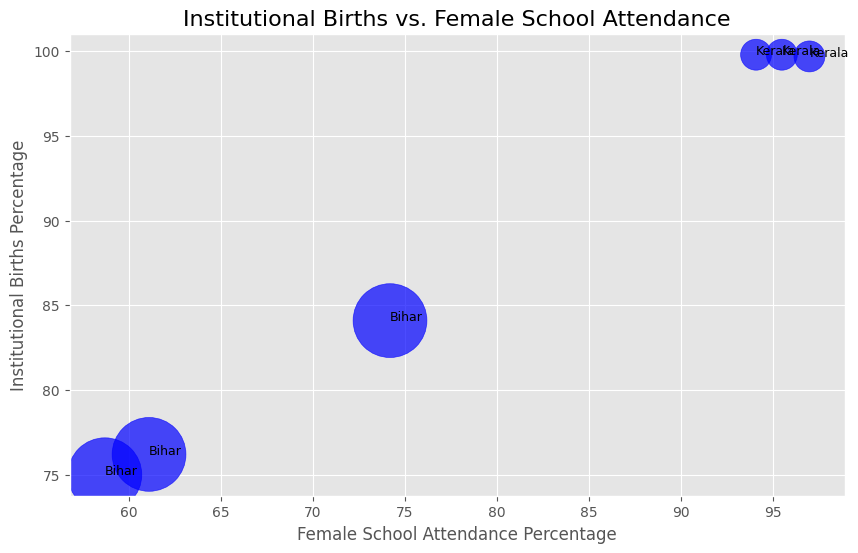

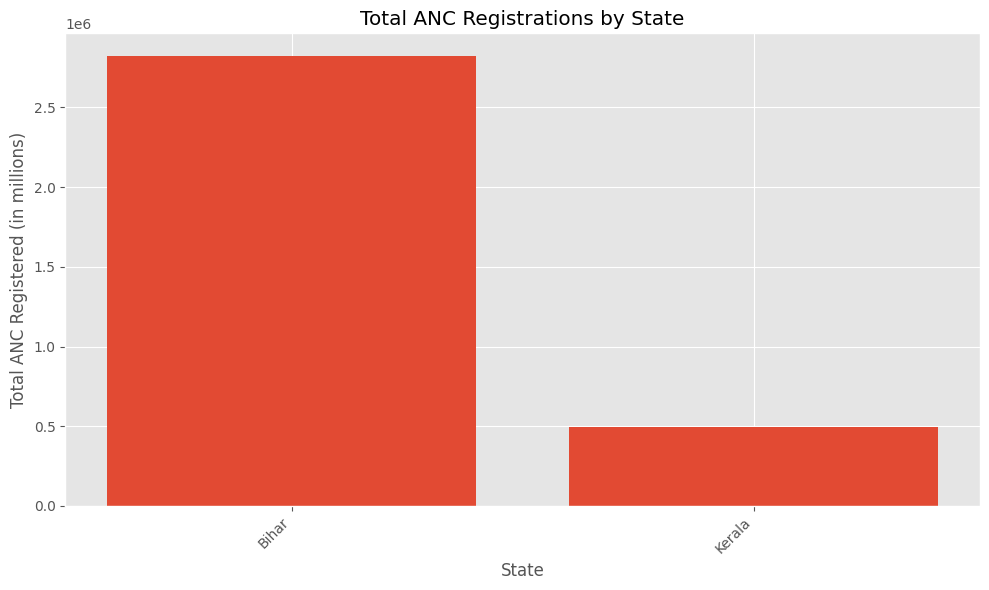

In [17]:
# --- STEP 6.1: DESCRIPTIVE STATISTICS ---
print("--- Descriptive Statistics of our Final Merged Data ---")
print(final_df.describe())

# --- STEP 6.2: CORRELATION ANALYSIS ---
print("\n--- Correlation Matrix of Key Metrics ---")
# Select only the numerical columns for correlation
numerical_cols = final_df.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = final_df[numerical_cols].corr()
print(correlation_matrix)

# --- STEP 6.3: VISUALIZATION ---
print("\n--- Visualizations ---")
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

# Scatter plot: Institutional Births vs. Female School Attendance
plt.scatter(final_df['Female_School_Attendance_Pct'], final_df['Institutional_Births_Pct'], s=final_df['ANC Registered']/1000, alpha=0.7, c='b')
for i, state in enumerate(final_df['State']):
    plt.text(final_df['Female_School_Attendance_Pct'][i], final_df['Institutional_Births_Pct'][i], state, fontsize=9)
plt.title('Institutional Births vs. Female School Attendance', fontsize=16)
plt.xlabel('Female School Attendance Percentage')
plt.ylabel('Institutional Births Percentage')
plt.grid(True)
plt.show()

# Bar chart: ANC Registered across different states
plt.figure(figsize=(10, 6))
plt.bar(final_df['State'], final_df['ANC Registered'])
plt.title('Total ANC Registrations by State')
plt.xlabel('State')
plt.ylabel('Total ANC Registered (in millions)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
final_df.to_csv('final_health_data.csv', index=False)